# import

In [1]:
import time
import glob
import datetime
import random
import pickle
import numpy as np
import shutil
import os
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1) # (A)
import keras.optimizers  # (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from decimal import *
from keras.layers.recurrent import SimpleRNN, LSTM
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
from graphviz import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# funcs

In [2]:
def xgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {'objective':'binary:logistic', 
                  'n_estimators':16,
                  'use_label_encoder':False,
                 'max_depth':4,
                  'random_state':100,
                 }
    xgb_model = xgb.XGBClassifier(**param_dist)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    y_proba_train = xgb_model.predict_proba(x_train)[:,1]
    y_proba = xgb_model.predict_proba(x_test)[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    return xgb_model

def eval_proba(x_test, y_test, xgb_model):
    predict_proba = xgb_model.predict_proba(x_test.astype(float))
    df = pd.DataFrame(columns = ['alpha','score','Up precision','Down precision','Up recall','Down recall','num'])
    j=0
    
    
    for alpha in [0.70,0.8,0.9]:
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        for i in range(len(predict_proba)):
            row = predict_proba[i]
            label = np.argmax(row)
            proba = row[label]
            if proba > alpha:
                if y_test[i]==label:
                    if label==0:
                        acc_dict['TD'] += 1
                    else:
                        acc_dict['TU'] += 1
                else:
                    if label==0:
                        acc_dict['FD'] += 1
                    else:
                        acc_dict['FU'] += 1

        try:
            denom = 0
            for idx, key in enumerate(acc_dict):
                denom += acc_dict[key]
            if denom==0:continue


            TU = acc_dict['TU']
            FU = acc_dict['FU']
            TD = acc_dict['TD']
            FD = acc_dict['FD']
            score = (TU + TD)/(denom)
            prec_u = TU/(TU + FU)
            prec_d = TD/(TD + FD)
            recall_u = TU/(TU + FD)
            recall_d = TD/(TD + FU)
            col_list = [alpha,score,prec_u,prec_d,recall_u,recall_d,denom]
            df.loc[j] = col_list
            j+=1
        except:
            print("division by zero.")
    return df

def easy_plot(df,xlabel='episode',ylabel='reward'):
    plt.subplots(figsize=(10, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.plot(df)
    plt.show()

# classes

In [3]:
class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)

class MakeTrainData():
    
    
    def __init__(self, df_con, test_rate=0.8, questions_index = [], is_bit_search=False,is_category=True,ma_short=5,ma_long=25):
        self.df_con = df_con
        self.test_rate = test_rate
        self.questions_index = questions_index
        self.is_bit_search = is_bit_search
        self.is_category = is_category
        self.ma_short = ma_short
        self.ma_long = ma_long
        
        
    def labeling(self):
        if self.is_category:
            up=1
            down=0
        else:
            up=[0,1]
            down=[1,0]
        
        
        return up,down
    
    
    def append_onehotlist(self, one_hot_list, questions):
        for i in range(len(questions)):
            if questions[i]:
                one_hot_list.append(1)
            else:
                one_hot_list.append(0)
                
                
    def add_ma(self):
        df_process = self.df_con.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        return df_process
                
    
    def make_question_column(self):
        column_questions = [
            
            'dawp_5',
            'dawp_4',
            'dawp_3',
            'dawp_2',
            'dawp_1',
            'nikkeip_5',
            'nikkeip_4',
            'nikkeip_3',
            'nikkeip_2',
            'nikkeip_1',
            'diff_rate',
            'nikkei_volumep',
            'ma_short',
            'ma_long'
        
        ]
        return column_questions
        
        
                
                
    
    def make_data(self):
        selected_column = []
        if self.is_bit_search:
            for i in self.questions_index:
                selected_column.append(self.column[i])
            dfx = pd.DataFrame(columns = selected_column)
        else:
            dfx = pd.DataFrame(columns = self.make_question_column())
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(self.ma_long,len(self.df_con)-1):
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
            df_ma = self.add_ma()
            ma_short = df_ma['ma_short'].iloc[i]
            ma_long  = df_ma['ma_long'].iloc[i]
            
            
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                diff_rate,
                nikkei_volumep,
                ma_short,
                ma_long
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            dfx.loc[self.df_con.index[i]] = selected_questions
            tommorow_close = self.df_con['close'].iloc[i+1]
            today_close    = self.df_con['close'].iloc[i]
            if tommorow_close>today_close:
                df_ans.append(up)
            else:
                df_ans.append(down)
                
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        y_train = df_ans[:int(len(dfx)*self.test_rate)]
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        y_test  = df_ans[int(len(dfx)*self.test_rate):]
        
        
        return x_train, y_train, x_test, y_test
    
class PlotTrade():
    
    
    def __init__(self, df_chart):
        self.df_chart = df_chart
        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.ax.plot(self.df_chart['close'])
        
        
    def add_span(self, start_time,end_time):
        self.ax.axvspan(start_time, end_time, color="gray", alpha=0.3)
        
    
    def add_plot(self, df_plot):
        self.ax.plot(df_plot)
        
        
    def show(self):
        self.ax.grid()
        labels = self.ax.get_xticklabels()
        plt.setp(labels, rotation=15, fontsize=12)
        plt.show()    
        
class XGBSimulation():
    
    
    def __init__(self, xgb_model, alpha=0.70):
        self.xgb_model = xgb_model
        self.alpha = alpha
        
    
    def make_df_con(self, path_tpx,path_daw):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
        df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
        return df_tmp
    
    
    def make_check_data(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        mk = MakeTrainData(df_con,test_rate=1.0)
        x_check, y_check, x_dummy, y_dummy = mk.make_data()
        self.ma_short = mk.ma_short
        self.ma_long = mk.ma_long
        return x_check, y_check
    
    
    def eval_proba(self, x_test, y_test):
        predict_proba = self.xgb_model.predict_proba(x_test.astype(float))
        df = pd.DataFrame(columns = ['score','Up precision','Down precision','Up recall','Down recall','num'])
        j=0
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        
        
        for i in range(len(predict_proba)):
            row = predict_proba[i]
            label = np.argmax(row)
            proba = row[label]
            if proba > self.alpha:
                if y_test[i]==label:
                    if label==0:
                        acc_dict['TD'] += 1
                    else:
                        acc_dict['TU'] += 1
                else:
                    if label==0:
                        acc_dict['FD'] += 1
                    else:
                        acc_dict['FU'] += 1


        denom = 0
        for idx, key in enumerate(acc_dict):
            denom += acc_dict[key]
        
        try:
            TU = acc_dict['TU']
            FU = acc_dict['FU']
            TD = acc_dict['TD']
            FD = acc_dict['FD']
            score = (TU + TD)/(denom)
            prec_u = TU/(TU + FU)
            prec_d = TD/(TD + FD)
            recall_u = TU/(TU + FD)
            recall_d = TD/(TD + FU)
            col_list = [score,prec_u,prec_d,recall_u,recall_d,denom]
            df.loc[j] = col_list
            j+=1
            return df
        except:
            print("division by zero")
            
        
    def return_df_con(self,path_tpx,path_daw):
        df_con =  self.make_df_con(path_tpx,path_daw)
        return df_con
        
        
    def simulate(self, path_tpx, path_daw, is_validate=False,strategy='normal'):
        x_check, y_check = self.make_check_data(path_tpx,path_daw)
        length = len(x_check)
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        trade_count = 0
        df_con = self.return_df_con(path_tpx,path_daw).iloc[self.ma_long:-1]
        pl = PlotTrade(df_con)
        prf_list = []
        self.pr_log = pd.DataFrame()
        self.pr_log.index = x_check.index
        self.pr_log['reward'] = [0.0] * len(self.pr_log)
        self.pr_log['eval_reward'] = self.pr_log['reward'].tolist()
        eval_price = 0
        total_eval_price = 0


        for i in range(length-1):
            
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
            total_eval_price = prf
            self.pr_log['reward'].loc[df_con.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
#             label==0 -> down
#             label==1 -> up
            
            if strategy=='normal':
            
                if not is_bought:
    #                 下がって買い
                    if label==0 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 上がって売り
                    if label==1 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
                        
                        
            elif strategy=='reverse':
                
                if not is_bought:
    #                 上がって買い
                    if label==1 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 下がって売り
                    if label==0 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
            else:
                print("No such strategy.")
                return 
                  
        
        if is_bought:
            index_sell = df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            pl.add_span(start_time,end_time)

        
        self.pr_log['reward'].loc[df_con.index[-1]] = prf 
        self.pr_log['eval_reward'].loc[df_con.index[-1]] = total_eval_price
        prf_array = np.array(prf_list)
        
        
        try:
            if not is_validate:
                print("Total profit :{}".format(prf))
                print("Trade count  :{}".format(trade_count))
                print("Max profit   :{}".format(prf_array.max()))
                print("Min profit   :{}".format(prf_array.min()))
                print("Mean profit  :{}".format(prf_array.mean()))
                df = self.eval_proba(x_check,y_check)
                print(df)
                print("")
                pl.show()
        except:
            print("no trade")
                    
    
    def show_result(self, path_tpx,path_daw,strategy='normal'):
        x_check, y_check = self.make_check_data(path_tpx,path_daw)
       
        
        self.simulate(x_check,y_check,strategy)
        
        
    def return_profit_rate(self, path_tpx,path_daw,wallet=250,strategy='normal'):
        self.simulate(path_tpx,path_daw, is_validate=True,strategy=strategy)
        self.pr_log['reward'] = self.pr_log['reward'].map(lambda x: x/wallet)
        self.pr_log['eval_reward'] = self.pr_log['eval_reward'].map(lambda x: x/wallet)
        return self.pr_log
        

# path_

In [4]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_toyota = '/Users/rince/Desktop/StockPriceData/Stock_index/07Toyota.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

# load df

In [5]:
df_tpx = DataFramePreProcessing(path_tpx).load_df()
df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
daw_p = df_daw.pct_change()
df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)


# make data 

In [6]:
x_train, y_train, x_test, y_test = MakeTrainData(df_tmp).make_data()


# XGB 10個分のシミュレーション

# Data format

In [62]:
x_check,y_check = sl.make_check_data(path_tpx_sim,path_daw_sim)

In [10]:
type(x_train), type(y_train)

(pandas.core.frame.DataFrame, list)

# make model

AUC train: 0.860577203982112
AUC test : 0.6767285722020684
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       219
           1       0.65      0.65      0.65       253

    accuracy                           0.63       472
   macro avg       0.63      0.63      0.63       472
weighted avg       0.63      0.63      0.63       472



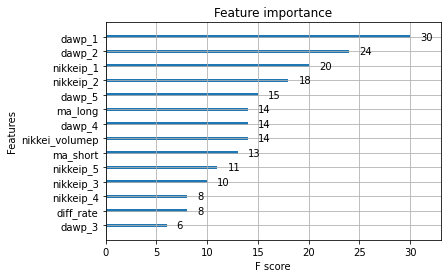

In [16]:
xgb_model = xgb_pred(x_train, y_train, x_test, y_test)

# simulation

In [19]:
path_daw_sim = '/Users/rince/Desktop/StockPriceData/DAW/*.csv'
path_tpx_sim = '/Users/rince/Desktop/StockPriceData/TOPIX/*.csv'
file1 =  glob.glob(path_tpx_sim)
file2 =  glob.glob(path_daw_sim)

path_tpx_sim = sorted(file1)[-1]
path_daw_sim = sorted(file2)[-1]

Total profit :106.0
Trade count  :214
Max profit   :140.0
Min profit   :-179.0
Mean profit  :0.4953271028037383
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.901073       0.88764        0.916244   0.922897     0.878345  839.0



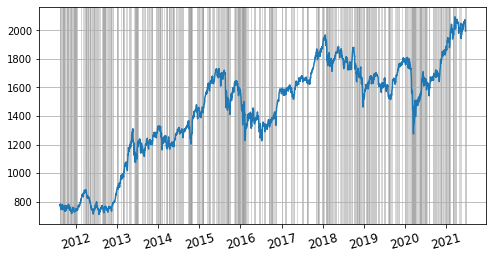

In [67]:
sl = XGBSimulation(xgb_model)
sl.simulate(path_tpx, path_daw, is_validate=False,strategy='normal')

# pr_log

# 注意点
xgbだけ, pathで指定する方法なので, pathのcsvデータに, 2021のデータにしないと, 累積収益率の計算がおかしくなる

In [41]:
x_train

,dawp_5,dawp_4,dawp_3,dawp_2,dawp_1,nikkeip_5,nikkeip_4,nikkeip_3,nikkeip_2,nikkeip_1,diff_rate,nikkei_volumep,ma_short,ma_long
2011-08-11,0.005352,-0.055464,0.039771,-0.046249,0.039494,-0.032491,-0.019900,-0.019036,0.009056,-0.005128,0.015464,-0.361288,784.2,845.28
2011-08-12,-0.055464,0.039771,-0.046249,0.039494,0.011281,-0.019900,-0.019036,0.009056,-0.005128,-0.005155,0.019430,-0.580390,777.8,841.08
2011-08-15,0.039771,-0.046249,0.039494,0.011281,0.018979,-0.019036,0.009056,-0.005128,-0.005155,0.010363,0.011538,-0.097242,776.2,837.12
2011-08-16,-0.046249,0.039494,0.011281,0.018979,-0.006703,0.009056,-0.005128,-0.005155,0.010363,0.005128,0.010204,-0.029312,778.4,833.44
2011-08-17,0.039494,0.011281,0.018979,-0.006703,0.000375,-0.005128,-0.005155,0.010363,0.005128,-0.003827,0.010243,-0.312006,778.6,830.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-04,0.002766,0.004416,0.002592,0.006694,0.000000,-0.000615,0.022154,0.002408,-0.009009,0.008485,0.004207,-0.078450,1653.0,1617.00
2019-07-05,0.004416,0.002592,0.006694,0.000000,-0.001627,0.022154,0.002408,-0.009009,0.008485,0.001202,0.004202,0.877966,1661.2,1620.40
2019-07-08,0.002592,0.006694,0.000000,-0.001627,-0.004308,0.002408,-0.009009,0.008485,0.001202,-0.027011,0.008637,-0.315265,1653.2,1622.52
2019-07-09,0.006694,0.000000,-0.001627,-0.004308,-0.000845,-0.009009,0.008485,0.001202,-0.027011,-0.003701,0.009907,0.120054,1643.2,1624.48


In [42]:
len(pr_log)

906

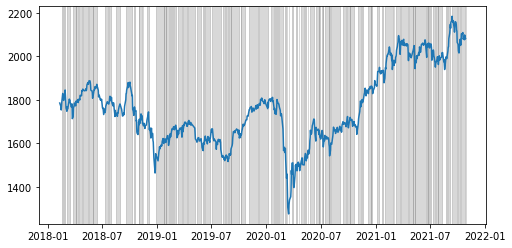

In [73]:
pr_log = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=250,strategy='reverse')
pr_log = pr_log[pr_log.index.year==2021]

In [75]:
pr_log['reward'] = pr_log['reward'].map(lambda x:x - pr_log['reward'].iloc[0])
pr_log['eval_reward'] = pr_log['eval_reward'].map(lambda x:x - pr_log['eval_reward'].iloc[0])

<ipython-input-75-3802c355ce7a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_log['reward'] = pr_log['reward'].map(lambda x:x - pr_log['reward'].iloc[0])
<ipython-input-75-3802c355ce7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_log['eval_reward'] = pr_log['eval_reward'].map(lambda x:x - pr_log['eval_reward'].iloc[0])


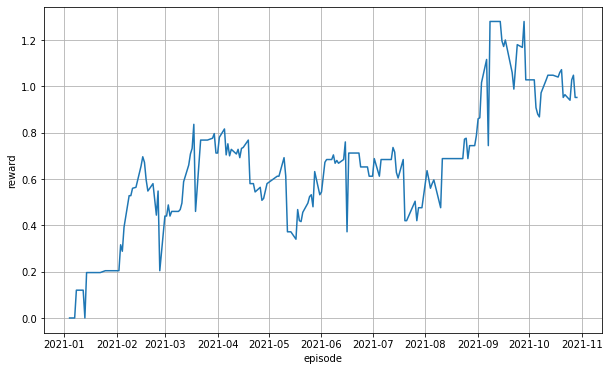

In [97]:
easy_plot(pr_log['eval_reward'])

<AxesSubplot:>

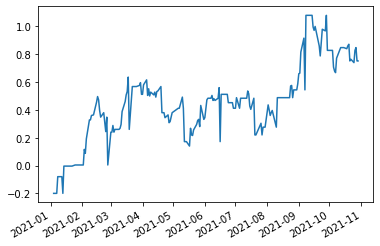

In [71]:
pr_log[pr_log.index.year==2021]['eval_reward'].plot()

# TOPIX指数平均

In [87]:
df_con = sl.make_df_con(path_tpx_sim,path_daw_sim)
df_con = df_con[df_con.index.year == 2021]

In [98]:
df_con['close']
pr_log_tpx = pd.DataFrame()
pr_log_tpx.index = df_con.index
wallet = 250
pr_log_tpx['reward'] = df_con['close'].map(lambda x:x - df_con['close'].iloc[0])
pr_log_tpx['reward'] = pr_log_tpx['reward'].map(lambda x:x/wallet)

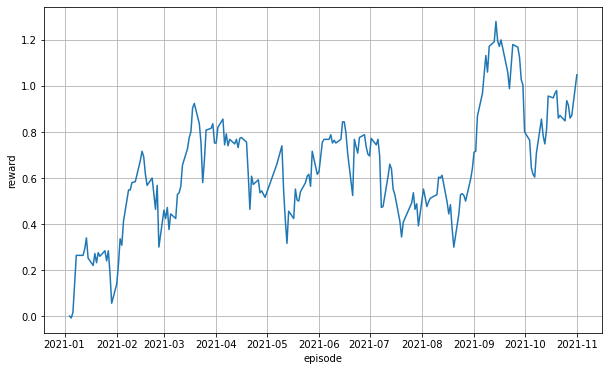

In [99]:
easy_plot(pr_log_tpx)

# Show tree structure

In [17]:
xgb.to_graphviz(xgb_model)

# XGB alpha と strategyで累積収益率の比較

strategy = 'normal'

*************************
alpha : 0.5
Total profit :537.0
Trade count  :577
Max profit   :116.0
Min profit   :-186.0
Mean profit  :0.9306759098786829
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.747034      0.741985        0.753333   0.789602      0.70062  2360.0



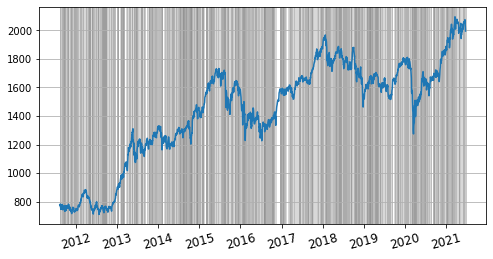

<ipython-input-100-aed47b6643cf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-100-aed47b6643cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.6
Total profit :213.0
Trade count  :339
Max profit   :116.0
Min profit   :-170.0
Mean profit  :0.6283185840707964
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.837491       0.83697        0.838141    0.86587     0.804615  1403.0



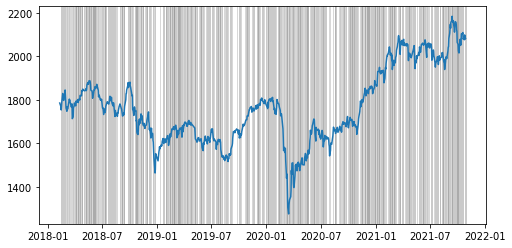

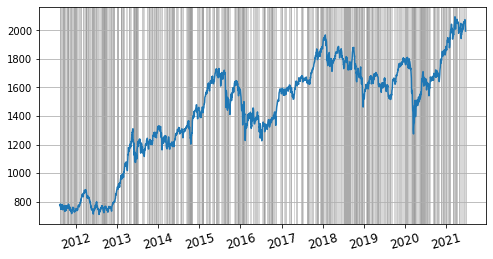

<ipython-input-100-aed47b6643cf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-100-aed47b6643cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.7
Total profit :106.0
Trade count  :214
Max profit   :140.0
Min profit   :-179.0
Mean profit  :0.4953271028037383
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.901073       0.88764        0.916244   0.922897     0.878345  839.0



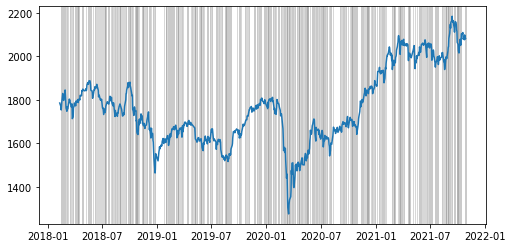

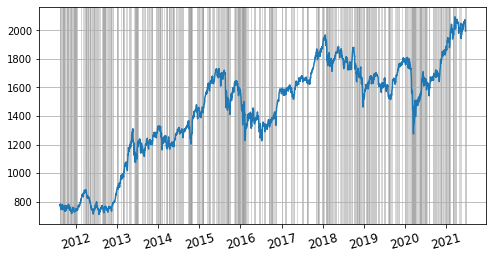

<ipython-input-100-aed47b6643cf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-100-aed47b6643cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.8
Total profit :-144.0
Trade count  :106
Max profit   :95.0
Min profit   :-163.0
Mean profit  :-1.3584905660377358
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.939785      0.928287        0.953271   0.958848     0.918919  465.0



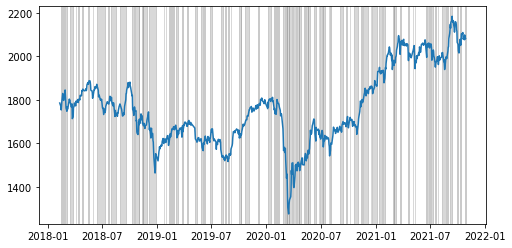

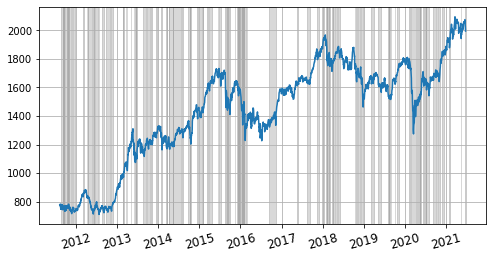

<ipython-input-100-aed47b6643cf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-100-aed47b6643cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.9
Total profit :651.0
Trade count  :19
Max profit   :328.0
Min profit   :-193.0
Mean profit  :34.26315789473684
      score  Up precision  Down precision  Up recall  Down recall   num
0  0.977011      0.979167        0.974359   0.979167     0.974359  87.0



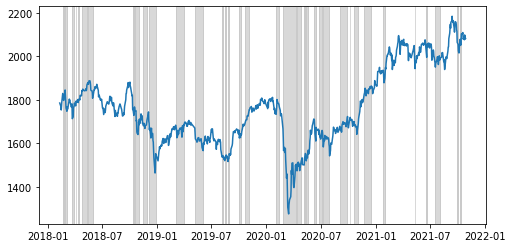

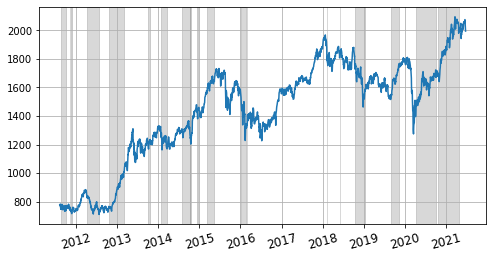

<ipython-input-100-aed47b6643cf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-100-aed47b6643cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


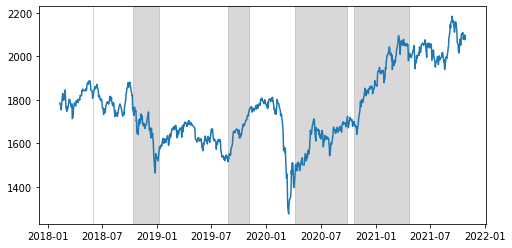

In [100]:
pr_log = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(xgb_model,alpha=alpha)
    sl.simulate(path_tpx, path_daw, is_validate=False,strategy='normal')
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=250,strategy='normal')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log[alpha] = pr_tmp

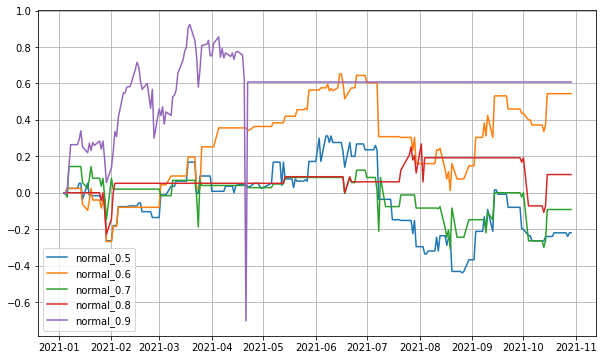

In [111]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log[0.5]['eval_reward'],label='normal_0.5')
plt.plot(pr_log[0.6]['eval_reward'],label='normal_0.6')
plt.plot(pr_log[0.7]['eval_reward'],label='normal_0.7')
plt.plot(pr_log[0.8]['eval_reward'],label='normal_0.8')
plt.plot(pr_log[0.9]['eval_reward'],label='normal_0.9')
plt.legend()
plt.grid(True)
plt.show()

strategy = 'reverse'

*************************
alpha : 0.5
Total profit :686.0
Trade count  :576
Max profit   :170.0
Min profit   :-92.0
Mean profit  :1.1909722222222223
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.747034      0.741985        0.753333   0.789602      0.70062  2360.0



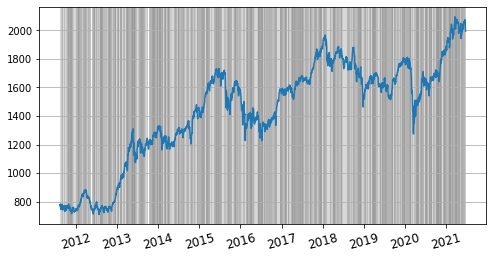

<ipython-input-112-862e9b1c4284>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-112-862e9b1c4284>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.6
Total profit :1010.0
Trade count  :338
Max profit   :184.0
Min profit   :-103.0
Mean profit  :2.9881656804733727
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.837491       0.83697        0.838141    0.86587     0.804615  1403.0



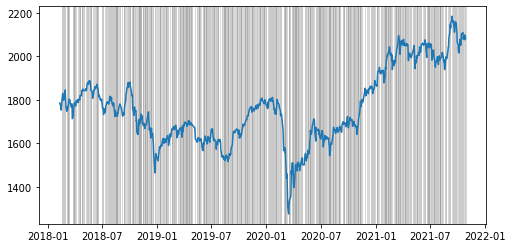

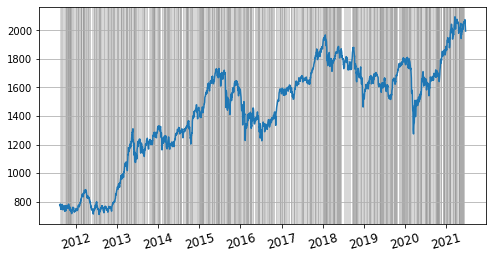

<ipython-input-112-862e9b1c4284>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-112-862e9b1c4284>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.7
Total profit :1117.0
Trade count  :213
Max profit   :186.0
Min profit   :-104.0
Mean profit  :5.244131455399061
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.901073       0.88764        0.916244   0.922897     0.878345  839.0



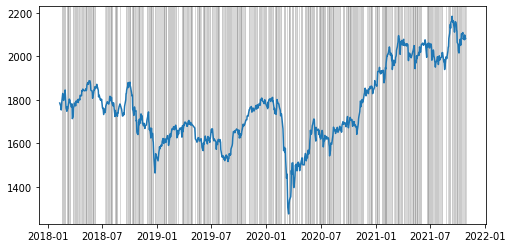

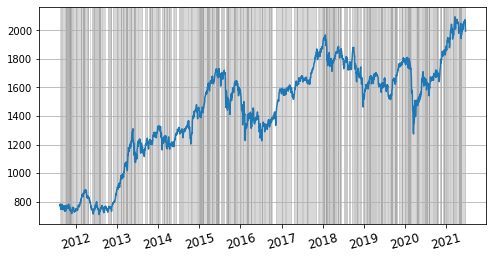

<ipython-input-112-862e9b1c4284>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-112-862e9b1c4284>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.8
Total profit :1359.0
Trade count  :106
Max profit   :214.0
Min profit   :-115.0
Mean profit  :12.820754716981131
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.939785      0.928287        0.953271   0.958848     0.918919  465.0



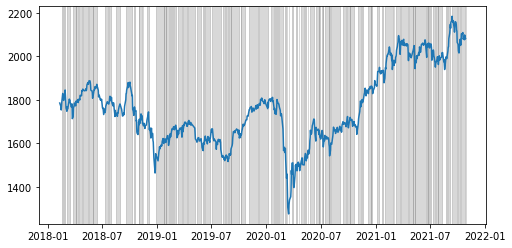

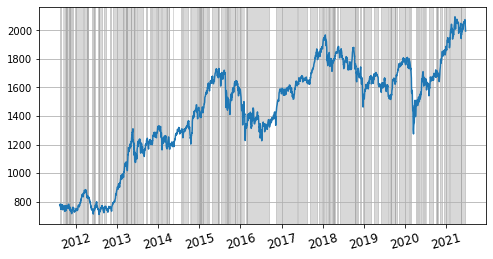

<ipython-input-112-862e9b1c4284>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-112-862e9b1c4284>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.9
Total profit :589.0
Trade count  :19
Max profit   :492.0
Min profit   :-306.0
Mean profit  :31.0
      score  Up precision  Down precision  Up recall  Down recall   num
0  0.977011      0.979167        0.974359   0.979167     0.974359  87.0



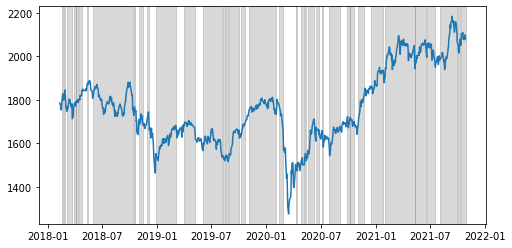

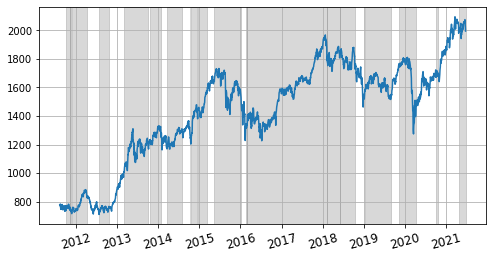

<ipython-input-112-862e9b1c4284>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-112-862e9b1c4284>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


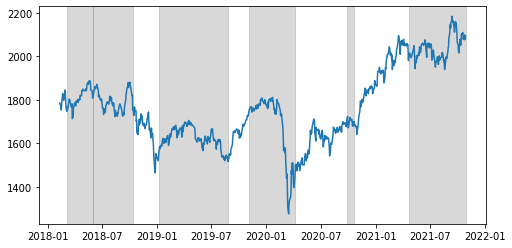

In [112]:
pr_log = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(xgb_model,alpha=alpha)
    sl.simulate(path_tpx, path_daw, is_validate=False,strategy='reverse')
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=250,strategy='reverse')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log[alpha] = pr_tmp

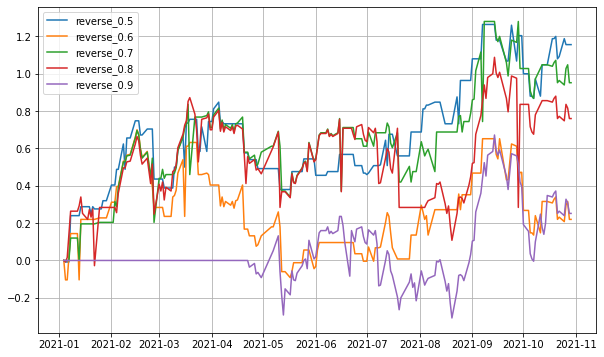

In [114]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log[0.5]['eval_reward'],label='reverse_0.5')
plt.plot(pr_log[0.6]['eval_reward'],label='reverse_0.6')
plt.plot(pr_log[0.7]['eval_reward'],label='reverse_0.7')
plt.plot(pr_log[0.8]['eval_reward'],label='reverse_0.8')
plt.plot(pr_log[0.9]['eval_reward'],label='reverse_0.9')
plt.legend()
plt.grid(True)
plt.show()